## Traffic Density VS Number of Passengers using Public Transportation
    Joseph Antony
    17th June 2023

In [1]:
import warnings
import numpy as np

import polars as pl
pl.enable_string_cache(True)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks", palette="muted", color_codes=True)

warnings.filterwarnings("ignore")

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.weight'] = 'bold'

In [2]:
%%time

select_Cols = [
    'DATE_TIME', 'GEOHASH', 'NUMBER_OF_VEHICLES', 'HIGHWAY_TRNSPRT_PSNGRS', 
    'SEA_TRNSPRT_PSNGRS', 'RAIL_TRNSPRT_PSNGRS', 'IS_COVID_RESTRICTION'
]

trnsprt = ['HIGHWAY_TRNSPRT_PSNGRS', 'SEA_TRNSPRT_PSNGRS', 'RAIL_TRNSPRT_PSNGRS']


pl_df = (
    # Scan parquet
    pl.scan_parquet("datasets/00_tr_df_merged/tr_ist_td_merged_full.zstd")

    # Select columns
    .select(select_Cols)

    # Passenger data was for the whole of Istanbul and not at GEOHASH level.
    # Aggregating by DATE_TIME and taking sum of number of vehicles and mean of publoc transportation cols.
    .groupby(['DATE_TIME', 'IS_COVID_RESTRICTION'])
    .agg([pl.col('NUMBER_OF_VEHICLES').sum(), 
          pl.col(trnsprt).mean()])

    # change extract datetime features and change datatypes
    .with_columns(pl.col('DATE_TIME').dt.date().alias('DATE'),
                  pl.col('DATE_TIME').dt.month().alias('MONTH').cast(pl.UInt8),
                  pl.col('DATE_TIME').dt.year().alias('YEAR').cast(pl.UInt16),
                  pl.col('DATE_TIME').dt.hour().alias('HOUR').cast(pl.UInt8),
                  pl.col('DATE_TIME').dt.weekday().alias('DAYOFWEEK').cast(pl.UInt8),
                  pl.col(trnsprt).cast(pl.UInt32),
                  pl.col('NUMBER_OF_VEHICLES').cast(pl.UInt32))

    # Sort by DATE_TIME
    .sort('DATE_TIME')
).collect(streaming=True)

pl_df.head()

Wall time: 18 s


DATE_TIME,IS_COVID_RESTRICTION,NUMBER_OF_VEHICLES,HIGHWAY_TRNSPRT_PSNGRS,SEA_TRNSPRT_PSNGRS,RAIL_TRNSPRT_PSNGRS,DATE,MONTH,YEAR,HOUR,DAYOFWEEK
datetime[ns],bool,u32,u32,u32,u32,date,u8,u16,u8,u8
2020-01-01 00:00:00,false,95483,15430,2211,31247,2020-01-01,1,2020,0,3
2020-01-01 01:00:00,false,83608,12108,1464,27136,2020-01-01,1,2020,1,3
2020-01-01 02:00:00,false,63463,9168,815,13970,2020-01-01,1,2020,2,3
2020-01-01 03:00:00,false,46426,6585,517,8190,2020-01-01,1,2020,3,3
2020-01-01 04:00:00,false,37562,5054,219,5310,2020-01-01,1,2020,4,3


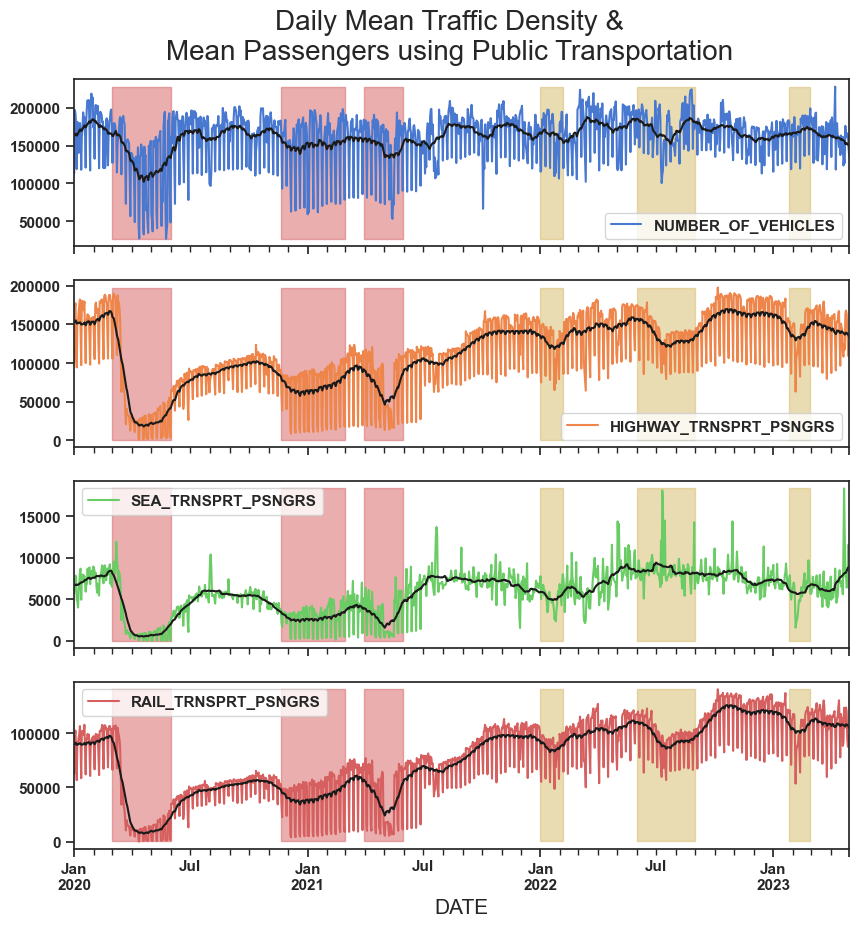

In [10]:
# List of max values of columns
mean_max_vals = (
    pl_df.groupby('DATE')
    .agg(pl.col(['NUMBER_OF_VEHICLES'] + trnsprt).mean())
    .max()
    .to_pandas()
    .values[0][1:]
)

# List of min values of columns
mean_min_vals = (
    pl_df.groupby('DATE')
    .agg(pl.col(['NUMBER_OF_VEHICLES'] + trnsprt).mean())
    .min()
    .to_pandas()
    .values[0][1:]
)

# Daily time series plot
axes = (
    pl_df.groupby('DATE')
    .agg(pl.col(['NUMBER_OF_VEHICLES'] + trnsprt).mean())
    .sort('DATE')
    .to_pandas()
    .set_index('DATE')
    .plot(subplots=True, figsize=(10, 10))
)

# 30-day rolling mean plot
(
    pl_df.groupby('DATE')
    .agg(pl.col(['NUMBER_OF_VEHICLES'] + trnsprt).mean())
    .sort('DATE')
    .with_columns(pl.exclude('DATE').rolling_mean(window_size=30, min_periods=7, center=True))
    .to_pandas()
    .set_index('DATE')
    .plot(subplots=True, ax=axes, color='k', legend=False)
)


for ax, min_val, max_val in zip(axes.flatten(), mean_min_vals, mean_max_vals):
    # Areas representing COVID time period are shaded in red
    ax.fill_between(x=("2020-03-01", "2020-05-31"), y1=min_val, y2=max_val, color='r', alpha = 0.5)
    ax.fill_between(x=("2020-11-20", "2021-02-28"), y1=min_val, y2=max_val, color='r', alpha = 0.5)
    ax.fill_between(x=("2021-03-30", "2021-05-31"), y1=min_val, y2=max_val, color='r', alpha = 0.5)

    # The trend lines in this time periods also goes down.
    # The cause is unknown, so shading these areas in yellow.
    ax.fill_between(x=("2022-01-01", "2022-02-05"), y1=min_val, y2=max_val, color='y', alpha = 0.5)
    ax.fill_between(x=("2022-06-01", "2022-08-31"), y1=min_val, y2=max_val, color='y', alpha = 0.5)
    ax.fill_between(x=("2023-01-25", "2023-02-28"), y1=min_val, y2=max_val, color='y', alpha = 0.5)


plt.suptitle("Daily Mean Traffic Density &\nMean Passengers using Public Transportation", fontsize=20, y=0.95);

    The above plots illustrates daily mean time series of traffic density and number of passengers using various public transporations. The black lines in each of the plots represents 30-day rolling mean. All four plots shows the same trends and patterns. Areas shaded in red represents the time when COVID controls were implemented by the government. During these COVID controls, all trends goes downwards. Right after COVID controls were lifted, all time series gradually increases again.

    In 2022, there are similar time periods when all trends goes down slightly, which is shaded in yellow. This most probably indicates the time when there is a winter and summer holiday respectively. Usually during these holidays, most people either travel outside of Istanbul or travel to the outskirts of Istanbul for vacation.

In [4]:
# to scale columns to values between 0 and 1
def scale_col(x):
    return (x-x.min())/(x.max()-x.min())

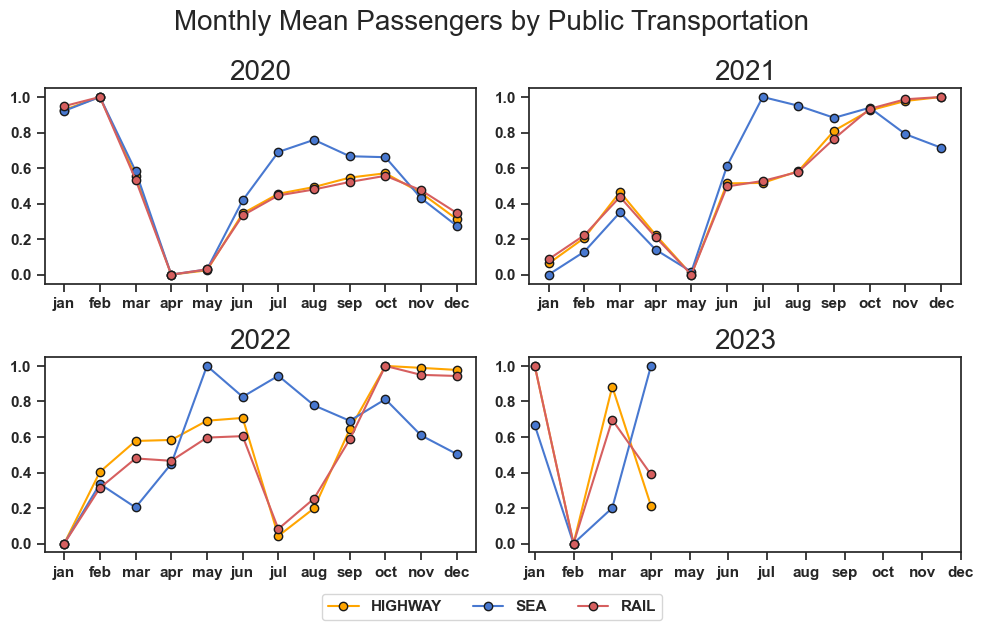

In [5]:
# Monthly Patterns
month_labels=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
cmp = {"HIGHWAY" : 'orange', "SEA" : 'b', "RAIL" : 'r'}

fig, axes = plt.subplots(2, 2, figsize=(10, 6), tight_layout=True)

for year, ax in zip([2020, 2021, 2022, 2023], axes.flatten()):

    (   
        # Filter by year
        pl_df.filter(pl.col('YEAR').eq(year))

        # group by the time period and take mean of num of passengers
        .groupby('MONTH')
        .agg(pl.col(trnsprt).mean())
        .sort('MONTH')

        # scale the columns
        .with_columns(scale_col(pl.col('HIGHWAY_TRNSPRT_PSNGRS')),
                      scale_col(pl.col('SEA_TRNSPRT_PSNGRS')),
                      scale_col(pl.col('RAIL_TRNSPRT_PSNGRS')))

        # rename columns for having cincise legend names in plot
        .rename({'HIGHWAY_TRNSPRT_PSNGRS' : 'HIGHWAY',
                'SEA_TRNSPRT_PSNGRS' : 'SEA',
                'RAIL_TRNSPRT_PSNGRS' : 'RAIL'})
        .to_pandas()
        .set_index('MONTH')

        # plot
        .plot(ax=ax, color=cmp, marker='o', mec='k')
    )
    
    ax.set_xlabel("")
    ax.set_xticks(ticks=np.arange(1, 13, 1), labels=month_labels)
    ax.legend().remove()
    ax.set_title(year)


# To display common legends
handles, labels = axes.flatten()[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.05));
plt.suptitle("Monthly Mean Passengers by Public Transportation", fontsize=20);

    For 2020 and 2021, passengers using all 3 public transportations follows similar trends. But from 2022 onwards, this trend changes.

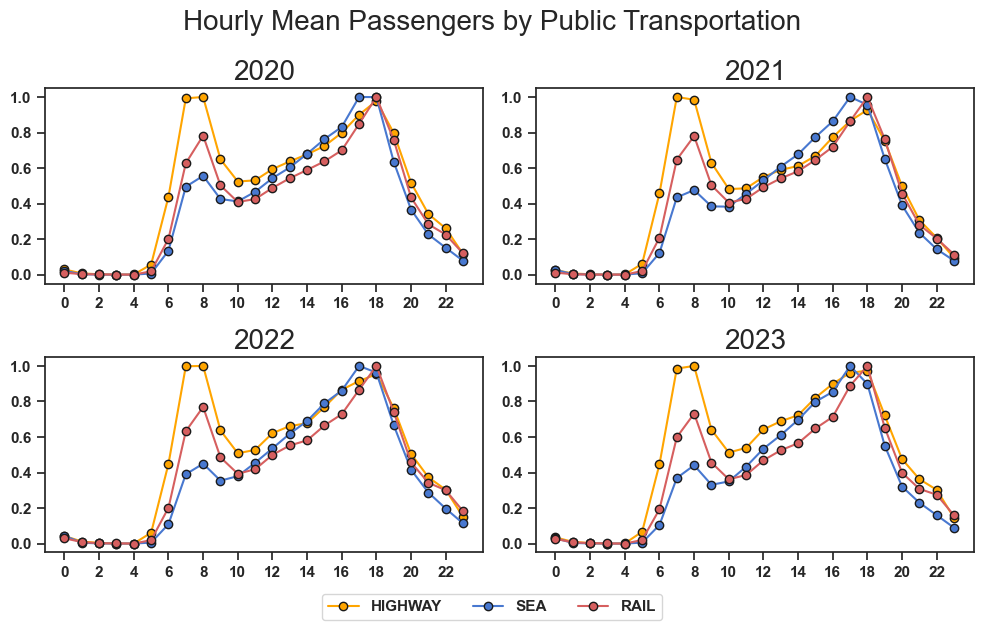

In [6]:
# Hourly Patterns
cmp = {"HIGHWAY" : 'orange', "SEA" : 'b', "RAIL" : 'r'}

fig, axes = plt.subplots(2, 2, figsize=(10, 6), tight_layout=True)

for year, ax in zip([2020, 2021, 2022, 2023], axes.flatten()):

    (
        pl_df.filter(pl.col('YEAR').eq(year))
        .groupby('HOUR')
        .agg(pl.col(trnsprt).mean())
        .sort('HOUR')
        .with_columns(scale_col(pl.col('HIGHWAY_TRNSPRT_PSNGRS')),
                      scale_col(pl.col('SEA_TRNSPRT_PSNGRS')),
                      scale_col(pl.col('RAIL_TRNSPRT_PSNGRS')))
        .rename({'HIGHWAY_TRNSPRT_PSNGRS' : 'HIGHWAY',
                'SEA_TRNSPRT_PSNGRS' : 'SEA',
                'RAIL_TRNSPRT_PSNGRS' : 'RAIL'})
        .to_pandas()
        .set_index('HOUR')
        .plot(ax=ax, color=cmp, marker='o', mec='k')
    )
    
    ax.set_xlabel("")
    ax.set_xticks(ticks=np.arange(0, 24, 2))
    ax.legend().remove()
    ax.set_title(year)


# To display common legends
handles, labels = axes.flatten()[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.05));
plt.suptitle("Hourly Mean Passengers by Public Transportation", fontsize=20);

    At an hourly level, the trend of number of passengers across all transportation modes are the same.

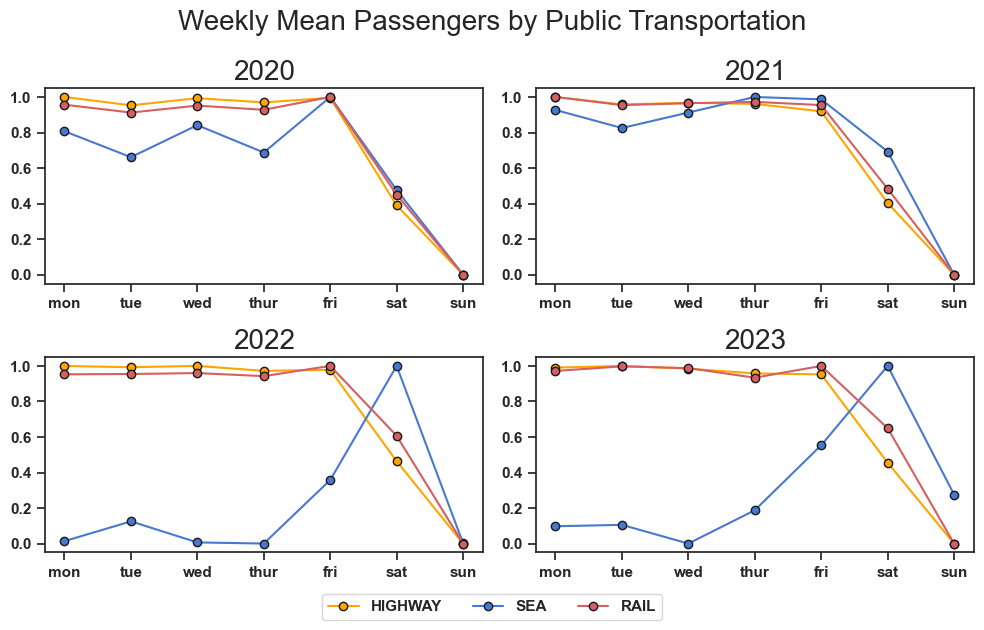

In [8]:
# Weekly Patterns
weekday_labels=["mon", "tue", "wed", "thur", "fri", "sat", "sun"]
cmp = {"HIGHWAY" : 'orange', "SEA" : 'b', "RAIL" : 'r'}

fig, axes = plt.subplots(2, 2, figsize=(10, 6), tight_layout=True)

for year, ax in zip([2020, 2021, 2022, 2023], axes.flatten()):

    (
        pl_df.filter(pl.col('YEAR').eq(year))
        .groupby('DAYOFWEEK')
        .agg(pl.col(trnsprt).mean())
        .sort('DAYOFWEEK')
        .with_columns(scale_col(pl.col('HIGHWAY_TRNSPRT_PSNGRS')),
                      scale_col(pl.col('SEA_TRNSPRT_PSNGRS')),
                      scale_col(pl.col('RAIL_TRNSPRT_PSNGRS')))
        .rename({'HIGHWAY_TRNSPRT_PSNGRS' : 'HIGHWAY',
                'SEA_TRNSPRT_PSNGRS' : 'SEA',
                'RAIL_TRNSPRT_PSNGRS' : 'RAIL'})
        .to_pandas()
        .set_index('DAYOFWEEK')
        .plot(ax=ax, color=cmp, marker='o', mec='k')
    )
    
    ax.set_xlabel("")
    ax.set_xticks(ticks=np.arange(1, 8, 1), labels=weekday_labels)
    ax.legend().remove()
    ax.set_title(year)


# To display common legends
handles, labels = axes.flatten()[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.05));
plt.suptitle("Weekly Mean Passengers by Public Transportation", fontsize=20);

    At a weekly level, although 2020 and 2021 saw similar patterns, 2022 onwards shows a different picture. Passengers using both HIGHWAY and RAIL transportations follows similar trends, where the number of passengers are higher on weekdays (monday to friday) compared to weekends.

    For SEA (ferries), the number of passengers are highest on Saturday, followed by Friday, compared to rest of the week.